In [1]:
from __future__ import print_function

%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy

In [2]:
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/2,
                               translation=(0, 1))
print(tform.params)

# Get the all sky image
hdu_list = fits.open('https://github.com/gammapy/gammapy-extra/blob/master/datasets/catalogs/fermi/gll_psch_v08.fit.gz?raw=true')
wcs1 = WCS(hdu_list[0].header)
all_sky = hdu_list[0].data.astype('float')

[[  6.12323400e-17  -1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   6.12323400e-17   1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


Filename: /home/adeel/.astropy/cache/download/py3/a4ac6330f75636794031fdc69ce71812
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   (512, 512)   int16   


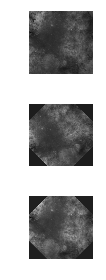

In [4]:
hips_tile_hdu = fits.open('https://github.com/hipspy/hips-extra/blob/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix450.fits?raw=true')
hips_tile_hdu.info()
wcs = WCS(hips_tile_hdu[0].header)
data = hips_tile_hdu[0].data.astype('float')

text = data#.text()

# @todo: pass in the four corners of HiPS tile
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/4,
                               translation=(text.shape[0]/2, -100))
rotated = tf.warp(text, tform)
back_rotated = tf.warp(rotated, tform.inverse)

fig, ax = plt.subplots(nrows=3)

ax[0].imshow(text, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(back_rotated, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [46]:
# Getting a new HiPS tile
nside = healpy.order2nside(order=3)
coords = healpy.boundaries(nside=nside, pix=377, nest=True)
theta, phi = healpy.vec2ang(np.transpose(coords), lonlat=False)
radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
print(tuple(radec.icrs.data.lat.deg))
print(tuple(radec.icrs.data.lon.deg))

(24.624318352164074, 19.471220634490685, 14.477512185929921, 19.471220634490685)
(84.375, 78.75, 84.375, 90.0)


In [72]:
def compute_corners(order, ipix):
    nside = healpy.order2nside(order)
    coords = healpy.boundaries(nside, ipix, nest=True)
    theta, phi = healpy.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    
    result = []
    for i in range(len(radec.ra.deg)):
        result.append([radec.ra.deg[i], radec.dec.deg[i]])
#     print(result)
    return result
    
compute_corners(3, 1)

[[50.625, 14.477512185929921],
 [45.0, 9.5940682268604593],
 [50.625, 4.78019184719916],
 [56.249999999999993, 9.5940682268604593]]

In [73]:
def draw_tile(warped, corners, out_shape, wcs):
    src = wcs.wcs_world2pix(corners, 0)
    dst = np.array([[511, 0], [511, 511], [0, 511], [0, 0]])

    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    return warped + tf.warp(text, tform3, output_shape=out_shape)
# all_sky.shape
# print([all_sky.shape[0] / 2., all_sky.shape[1] / 2.])
# healpy.query_disc(nside, angle.flatten, 900)
# angle = healpy.ang2vec(0, [900.0, 1800.0])
# healpy.vec2ang(np.array([ 0.17101007, 0.03015369, 0.98480775]))
# print(angle[])

194.69529747962952


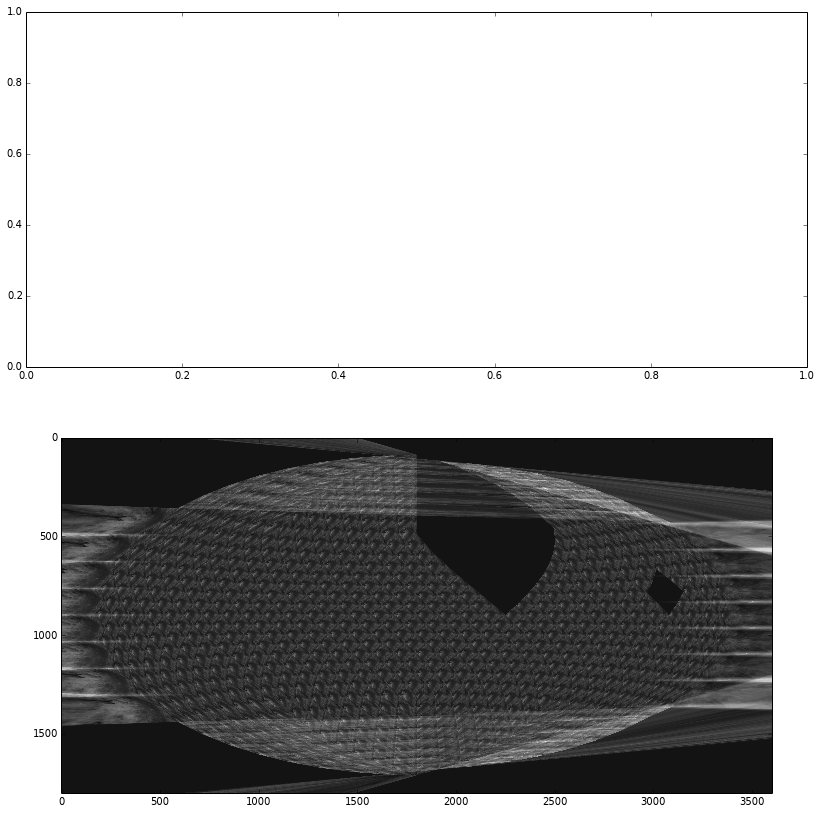

In [77]:
from astropy.visualization.wcsaxes import WCSAxes
import time
text = data
start = time.time()
warped = np.zeros((all_sky.shape)) # the output image size
for i in range(0, 700):
    corners = compute_corners(3, i)
    warped = draw_tile(warped, corners, all_sky.shape, wcs1)

fig, ax = plt.subplots(nrows=2, figsize=(14, 14))

# ax[0].imshow(all_sky, vmin=0, vmax=1, origin='upper', cmap=plt.cm.gray)
# ax[0].plot(src[:, 0], src[:, 1], '.r', )

ax[1].imshow(warped, origin='upper', cmap=plt.cm.gray)

end = time.time()
print(end - start)

# from astropy.visualization.wcsaxes import WCSAxes

# text = data

# corners = np.array([[264.375, -24.62431835], [258.75, -30.], [264.375, -35.68533471], [270., -30.]])
# center_corners = np.array([[84.375, 24.624318352164074], [78.75, 19.471220634490685], [84.375, 14.477512185929921], [90.0, 19.471220634490685]])

# warped = np.zeros((all_sky.shape)) # the output image size

# warped = draw_tile(warped, corners, all_sky.shape, wcs1)
# warped = draw_tile(warped, center_corners, all_sky.shape, wcs1)

# fig, ax = plt.subplots(nrows=2, figsize=(14, 14))

# ax[0].imshow(all_sky, vmin=0, vmax=1, origin='upper', cmap=plt.cm.gray)
# ax[0].plot(src[:, 0], src[:, 1], '.r', )

# ax[1].imshow(warped, origin='upper', cmap=plt.cm.gray)

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:412: UserWarning: The default of `mode` in `skimage.transform.swirl` will change to `reflect` in version 0.15.
  warn('The default of `mode` in `skimage.transform.swirl` '


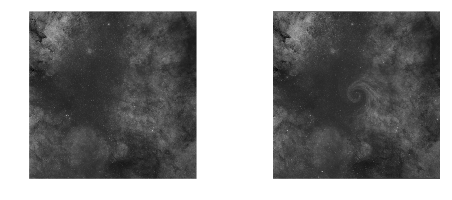

In [5]:
import matplotlib.pyplot as plt

# from skimage import data
from skimage.transform import swirl

data = np.array(data, dtype=float)
image = data#.checkerboard()
swirled = swirl(image, rotation=0, strength=10, radius=120)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),
                               sharex=True, sharey=True,
                               subplot_kw={'adjustable':'box-forced'})

ax0.imshow(image, cmap=plt.cm.gray, interpolation='none')
ax0.axis('off')
ax1.imshow(swirled, cmap=plt.cm.gray, interpolation='none')
ax1.axis('off')

plt.show()

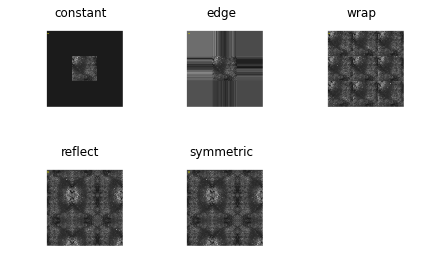

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import pad


img = data
img[:8, :8] += 1
img[:4, :4] += 1
img[:2, :2] += 1
img[:1, :1] += 2
img[8, 8] = 4

modes = ['constant', 'edge', 'wrap', 'reflect', 'symmetric']
fig, axes = plt.subplots(2, 3)
ax = axes.flatten()

for n, mode in enumerate(modes):
    img_padded = pad(img, pad_width=img.shape[0], mode=mode)
    ax[n].imshow(img_padded, cmap=plt.cm.gray, interpolation='nearest')
    ax[n].plot([15.5, 15.5, 31.5, 31.5, 15.5],
               [15.5, 31.5, 31.5, 15.5, 15.5], 'y--', linewidth=0.5)
    ax[n].set_title(mode)

for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

plt.tight_layout()
plt.show()

In [102]:
theta, phi = healpy.pix2ang(nside=8, ipix=[900,1800])
vector = healpy.ang2vec(theta, phi)
vector
# nside7

/usr/local/lib/python3.4/dist-packages/healpy/pixelfunc.py:478: RuntimeWarning: divide by zero encountered in _pix2ang_ring
  theta,phi = pixlib._pix2ang_ring(nside,ipix)
/usr/local/lib/python3.4/dist-packages/healpy/pixelfunc.py:478: RuntimeWarning: invalid value encountered in _pix2ang_ring
  theta,phi = pixlib._pix2ang_ring(nside,ipix)
/usr/local/lib/python3.4/dist-packages/healpy/pixelfunc.py:671: RuntimeWarning: invalid value encountered in cos
  return np.array([sintheta*np.cos(phi),
/usr/local/lib/python3.4/dist-packages/healpy/pixelfunc.py:672: RuntimeWarning: invalid value encountered in sin
  sintheta*np.sin(phi),


array([[ nan,  nan,  -1.],
       [ nan,  nan,  -1.]])